#  **Testing Gaussian EP on a given RBM**


In [241]:
using Pkg
using Plots
using Revise
using DelimitedFiles


┌ Warning: Your operating system has run out of inotify capacity.
│ Check the current value with `cat /proc/sys/fs/inotify/max_user_watches`.
│ Set it to a higher level with, e.g., `echo 65536 | sudo tee -a /proc/sys/fs/inotify/max_user_watches`.
│ This requires having administrative privileges on your machine (or talk to your sysadmin).
│ See https://github.com/timholy/Revise.jl/issues/26 for more information.
└ @ Revise /home/an-na/.julia/packages/Revise/9lZUE/src/packagedef.jl:39


In [242]:
include("../src/GaussianEP.jl")
include("../Sampling/Sampling.jl")
#Pkg.activate("/Users/luca/repos/GaussianEP/")
#using GaussianEP

Main.Sampling

In [243]:
# Number of visible and hidden units, Gaussian weigths
N = 12
M = 4
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [244]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M];
P0 = vcat(Pv,Ph);

In [245]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

it: 100 Δav: 7.406249159735978e-5


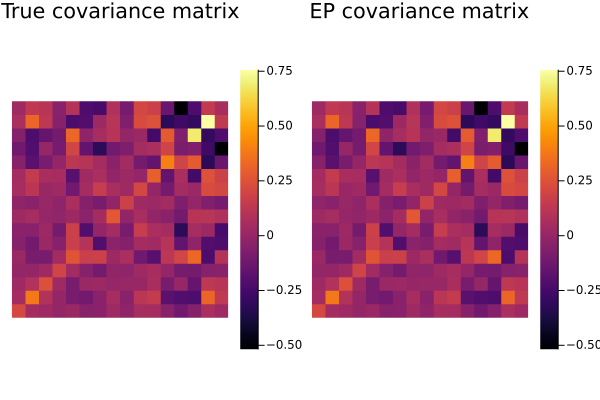

In [246]:
using Plots

Σan = GaussianEP.compute_analytic(w,Pv,Ph)
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [247]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 

Pv = [GaussianEP.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0 = vcat(Pv,Ph);

In [248]:
out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-7, maxiter=100000);
cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 100 Δav: 1.2481949613674104e-5


In [249]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, Pv, Ph);

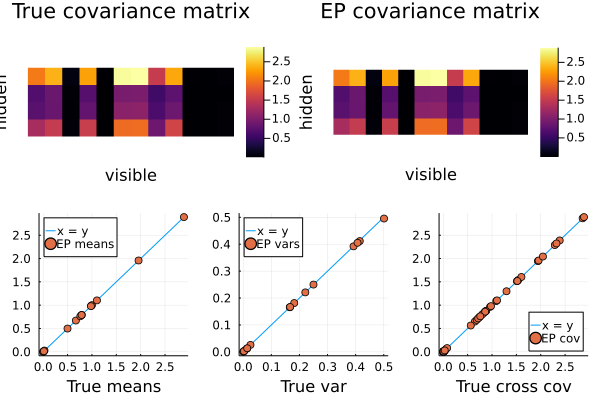

In [250]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [251]:
Pv = [Sampling.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [Sampling.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0mc = vcat(Pv,Ph);

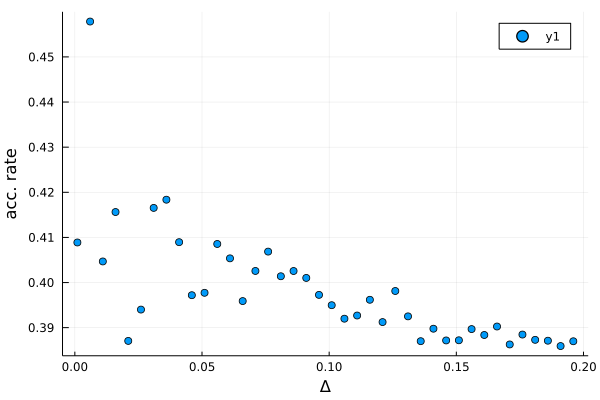

In [252]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.005:0.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/isZEW/src/args.jl:1260


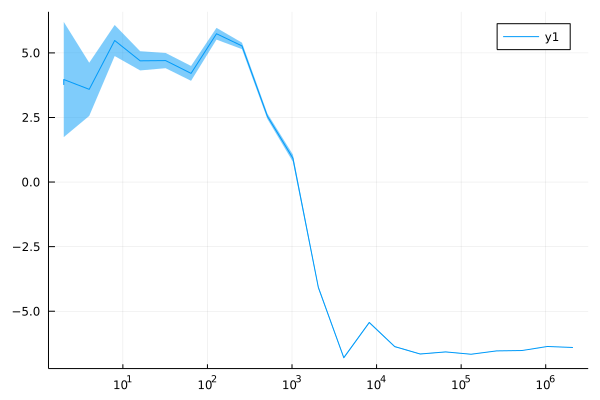

In [253]:
# Get thermalization time

Δ = 0.05
nblocks = 22
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [254]:
# Sampling using MCMC

Nconf = 10^5
Twait = 10^7
mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [255]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

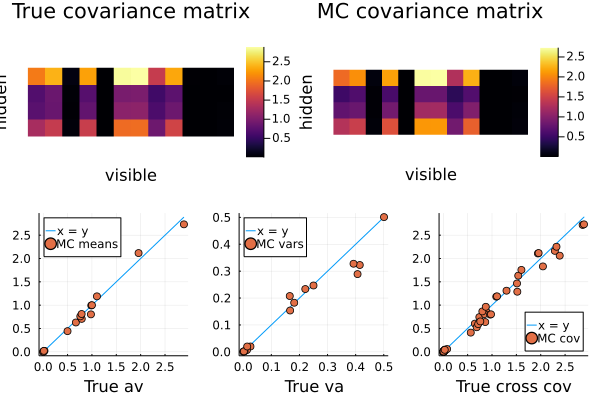

In [256]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [286]:
γ_start = 5.0
γ_final = 1.0
N_iter = 10^5
step = (γ_start - γ_final) / N_iter

γ = γ_start
init_state = nothing

μv = 0.0; βv = 30.0; # βv needs to be large
Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
for i=1:N_iter
    if mod(i,5000) == 0
        println("γ: ", γ)
    end
    Ph = [GaussianEP.ReLUPrior(γ,0.0) for j = 1:M ]
    P0 = vcat(Pv,Ph)
    if i==1
        out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-8)
    else
        out = GaussianEP.expectation_propagation(H, P0; state = init_state, epsconv = 1e-8)
    end
    γ -= step
    init_state = out.state
end


cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 100 Δav: 6.104374151716385e-7
γ: 4.80003999999869
γ: 4.60003999999738
γ: 4.4000399999960695
γ: 4.200039999994759
γ: 4.000039999993449
γ: 3.8000399999943593
γ: 3.6000399999952695
γ: 3.4000399999961797
γ: 3.20003999999709
γ: 3.000039999998
γ: 2.8000399999989103
γ: 2.6000399999998205
γ: 2.4000400000007307
γ: 2.200040000001641
γ: 2.000040000002551
γ: 1.8000400000023513
γ: 1.6000400000021513
γ: 1.4000400000019513
γ: 1.2000400000017513
it: 100 Δav: 9.222763885929908e-9
it: 100 Δav: 9.235662901119213e-9
it: 100 Δav: 9.248800836303417e-9
it: 100 Δav: 9.261962752304953e-9
it: 100 Δav: 9.275143764142513e-9
it: 100 Δav: 9.28835941493844e-9
it: 100 Δav: 9.301593717481182e-9
it: 100 Δav: 9.314851112662836e-9
it: 100 Δav: 9.32813959408918e-9
it: 100 Δav: 9.341444950905498e-9
it: 100 Δav: 9.354779617609665e-9
it: 100 Δav: 9.368139153309585e-9
it: 100 Δav: 9.381520893469997e-9
it: 100 Δav: 9.394931943518259e-9
it: 100 Δav: 9.408368306651482e-9
it: 100 Δav: 9.421825541977569e-9
it: 100 Δav: 9.43530

In [274]:
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [Sampling.ReLUPrior(γ_final,0.0) for j = 1:M ]
P0mc = vcat(Pv,Ph);

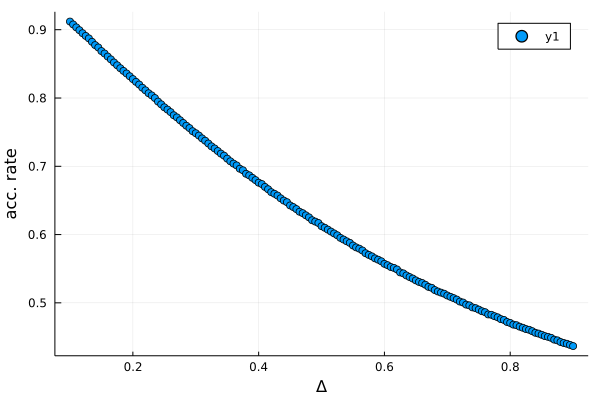

In [276]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.1:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/isZEW/src/args.jl:1260


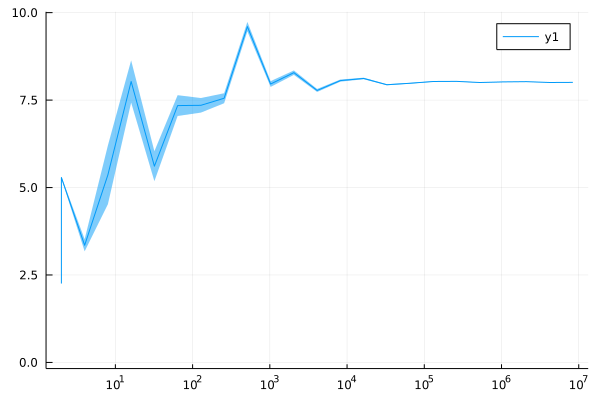

In [281]:

# Get thermalization time

Δ = 0.75
nblocks = 24
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [282]:
# Sampling using MCMC

Nconf = 10^7
Twait = 10^5
mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [283]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

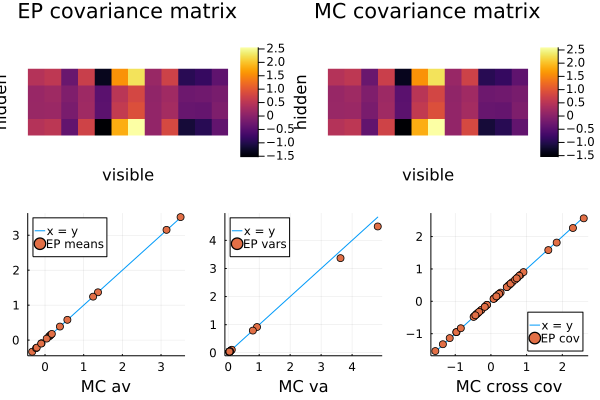

In [287]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)